In [1]:
%load_ext autoreload
%autoreload 2

This notebook is meant to accompany our paper with a live demonstration of three error mitigation techniques, including Measurement Error Calibration, unitary folding, and Trotterization Error Mitigation - the later of which is a novel error mitigation method developed in this work. Moreover, we will use a trotterization gate with fewer CNOTs than within the default trotterization gate given in this challenge.

# Imports

Please install all required packages, which include qiskit, cvxpy, tqdm, matplotlib, jupyter, numpy, scipy. 

In [2]:
from trott import *
from qiskit import IBMQ
from qiskit.providers.aer import QasmSimulator
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit

# Set up Circuits

First, let's set up the circuits we will measure to implement these error mitigation techniques. We begin by generating the 3 CNOT Trotterization gate.

In [3]:
trott_gate = gen_3cnot_trott_gate() # using improved 3cnot Trotterization Gate
qc_example = QuantumCircuit(3)
qc_example.append(trott_gate, [0,1,2])
qc_example.decompose().decompose().draw(fold=200)

┌───────────────────────────┐┌───┐        ┌───┐         ┌─────────┐                                                                          
q_0: ──■──┤ Rx(2*t - 1.5707963267949) ├┤ H ├──■─────┤ H ├──────■──┤ Rx(π/2) ├──────────────────────────────────────────────────────────────────────────
     ┌─┴─┐└────────┬─────────┬────────┘└───┘┌─┴─┐┌──┴───┴───┐┌─┴─┐├─────────┴┐     ┌───────────────────────────┐┌───┐        ┌───┐         ┌─────────┐ 
q_1: ┤ X ├─────────┤ Rz(2*t) ├──────────────┤ X ├┤ Rz(-2*t) ├┤ X ├┤ Rx(-π/2) ├──■──┤ Rx(2*t - 1.5707963267949) ├┤ H ├──■─────┤ H ├──────■──┤ Rx(π/2) ├─
     └───┘         └─────────┘              └───┘└──────────┘└───┘└──────────┘┌─┴─┐└────────┬─────────┬────────┘└───┘┌─┴─┐┌──┴───┴───┐┌─┴─┐├─────────┴┐
q_2: ─────────────────────────────────────────────────────────────────────────┤ X ├─────────┤ Rz(2*t) ├──────────────┤ X ├┤ Rz(-2*t) ├┤ X ├┤ Rx(-π/2) ├
                                                                              └───┘         └─────────┘              └───┘└──────────┘└───┘└──────────┘

In [4]:
trott_steps_range = np.arange(4,18,1) # range of trotterization steps (n) to use, (U_trott)^n
unitary_folding_steps_range = np.arange(0,10,1) # range of unitary folding steps (beta) to use, circuit = (U_trott^dag U_trott)^beta (U_trott)^n|psi_init>
qcs = gen_st_qcs_range(trott_gate, trott_steps_range, unitary_folding_steps_range=unitary_folding_steps_range) # generate tomography circuits
# qcs[10][-2].draw() 

In [5]:
qcs[(4,3)][-1].draw() # e.g. n=4 trott steps, beta=3 unitary folding steps example tomography circuit

»
q7_0: ─────────────────────────────────────────────────────────────»
           ┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
q7_1: ─────┤0           ├┤0           ├┤0           ├┤0           ├»
           │            ││            ││            ││            │»
q7_2: ─────┤            ├┤            ├┤            ├┤            ├»
      ┌───┐│            ││            ││            ││            │»
q7_3: ┤ X ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├┤1 Trot(π/4) ├»
      └───┘│            ││            ││            ││            │»
q7_4: ─────┤            ├┤            ├┤            ├┤            ├»
      ┌───┐│            ││            ││            ││            │»
q7_5: ┤ X ├┤2           ├┤2           ├┤2           ├┤2           ├»
      └───┘└────────────┘└────────────┘└────────────┘└────────────┘»
q7_6: ─────────────────────────────────────────────────────────────»
                                                                   »
c3: 3/═════════════════════════════════════════════════════════════»
                                                                   »
«                                                                    »
«q7_0: ──────────────────────────────────────────────────────────────»
«      ┌────────────┐┌───────────────┐┌────────────┐┌───────────────┐»
«q7_1: ┤0           ├┤0              ├┤0           ├┤0              ├»
«      │            ││               ││            ││               │»
«q7_2: ┤            ├┤               ├┤            ├┤               ├»
«      │            ││               ││            ││               │»
«q7_3: ┤1 Trot(π/4) ├┤1 Trot_dg(π/4) ├┤1 Trot(π/4) ├┤1 Trot_dg(π/4) ├»
«      │            ││               ││            ││               │»
«q7_4: ┤            ├┤               ├┤            ├┤               ├»
«      │            ││               ││            ││               │»
«q7_5: ┤2           ├┤2              ├┤2           ├┤2              ├»
«      └────────────┘└───────────────┘└────────────┘└───────────────┘»
«q7_6: ──────────────────────────────────────────────────────────────»
«                                                                    »
«c3: 3/══════════════════════════════════════════════════════════════»
«                                                                    »
«                                      ░          
«q7_0: ────────────────────────────────░──────────
«      ┌────────────┐┌───────────────┐ ░ ┌─┐      
«q7_1: ┤0           ├┤0              ├─░─┤M├──────
«      │            ││               │ ░ └╥┘      
«q7_2: ┤            ├┤               ├─░──╫───────
«      │            ││               │ ░  ║ ┌─┐   
«q7_3: ┤1 Trot(π/4) ├┤1 Trot_dg(π/4) ├─░──╫─┤M├───
«      │            ││               │ ░  ║ └╥┘   
«q7_4: ┤            ├┤               ├─░──╫──╫────
«      │            ││               │ ░  ║  ║ ┌─┐
«q7_5: ┤2           ├┤2              ├─░──╫──╫─┤M├
«      └────────────┘└───────────────┘ ░  ║  ║ └╥┘
«q7_6: ────────────────────────────────░──╫──╫──╫─
«                                      ░  ║  ║  ║ 
«c3: 3/═══════════════════════════════════╩══╩══╩═
«                                         0  1  2

# Prepare Backend

Our software is equipped to run these techniques on noiseless simulators, noisy simulators and real quantum hardware. The majority of these notebook will demonstrate our suite of error mitigation techniques using a noisy simulator modelled after the `ibmq_jakarta` quantum processor. Later, we will show how these generalizable techniques may be applied on real quantum hardware. 

In [6]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

In [7]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

# Run Simulations

In [8]:
# simply uncomment this cell to run simulations on the noisy jakarta simulator
# however, depending on your classical hardware, this may take anywhere between 2 hours and 2 minutes
# results = gen_results(qcs, backend=sim_noisy_jakarta, label="data/3cnot_noise_sim_unitary_folding")

# Load Data

In [9]:
# once simulations have been run, simply load in your results from the file within which they have been saved
results = np.load('data/3cnot_noise_sim_unitary_folding_results_20220423__112000.npy',allow_pickle=True).item()

# Run Analysis

Again, we will leverage three error mitigation techniques in this work:
1. Measurement Error Calibration [1]
2. Unitary Folding Extrapolation [2]
3. Trotterization Error Mitigation (novel technique developed in this work!)

First, we generate a Measurement Error Calibration fitter using the noisy simulator modelled after `ibmq_jakarta`, which can just as easily be swapped to another simulator or hardware backend.

In [10]:
meas_fitter = gen_meas_fitter(backend=sim_noisy_jakarta)

Then, using this Measurement Error Calibration fitter, we can first run Measurement Error Calibration on all measurement results. Next, we can run unitary folding extrapolation at each trotterization step number. Finally, we can extrapolate trotterization error down to zero. This is all done within `run_analysis`, as shown directly below and elaborated upon later in this notebook.

In [11]:
res_analysis = run_analysis(
    results, # raw results
    meas_fitter=meas_fitter, # Measurement Error Calibration fitter
    deepcopy=True, # this produces a deepcopy of results, instead of modifying the dict in place
    num_qubits=3, # this software may be applied to other multi qubit trotterization problems
    plotting=False, # plot or not
    unitary_folding=True, # set this to true to run unitary folding analysis
    min_r2_uf=0.94, # only unitary folding fits with an r^2 value greater than this can be used
    trott_step_min = 5, # minimum trott step number to use for Trotterization Error Mitigation
    trott_step_max = 10, # maximum trott step number to use for Trotterization Error Mitigation
    min_r2_trott=0.99, # only trott error extrapolation fits with an r^2 value greater than this can be used
)

Running Measurement Error Mitigation:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [02:35<00:00,  1.11s/it]


Generating Data Maps:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 1002.45it/s]


Generating Parity Values:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 46.42it/s]


Running Metric Analysis:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 66.16it/s]


Running Unitary Folding Extrapolation:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.94it/s]


Calculating Unitary Folding Extrapolated Fidelities:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.59it/s]


Running Trotterization Extrapolation:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.93it/s]


Calculating Trotterization Extrapolated Fidelity.


These methods extrapolate values of parity measurements (e.g. \<XYZ\>, \<ZIZ\>, ...). We then run MLE quantum state tomography using these extrapolated parity measurements. Then, we measure the fidelity of the reconstructed state to the target state |q1q3q5> = |011>. 

In [21]:
print("Fidelity of reconstructed state to target state: {:.5f}".format(1- res_analysis["total"]["trott_infid"]))

Fidelity of reconstructed state to target state: 0.96787


**By leveraging the error mitigation techniques listed above, we have achieved a fidelity of 96.8% on a noisy simulator modelled after `ibmq_jakarta`. This should, hopefully, excite the reader enough to join us on the following deep dive into the error mitigation techniques used in this work.**

# Technique: Measurement Error Calibration

This technique is written about well in Ref. [1]. We simply apply these calibration technique to all of our measurement results.

In [49]:
res_analysis_no_fitter = run_analysis(
    results, # raw results
    meas_fitter=None, # NO Measurement Error Calibration fitter
)

Skipping Measurement Error Mitigation:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 445863.75it/s]


Generating Data Maps:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 1072.21it/s]


Generating Parity Values:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 43.39it/s]


Running Metric Analysis:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:02<00:00, 62.46it/s]


Running Unitary Folding Extrapolation:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.01it/s]


Calculating Unitary Folding Extrapolated Fidelities:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.69it/s]


Running Trotterization Extrapolation:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.27it/s]


Calculating Trotterization Extrapolated Fidelity.


In [50]:
print("Fidelity of reconstructed state to target state: {:.5f}".format(1- res_analysis_no_fitter["total"]["trott_infid"]))

Fidelity of reconstructed state to target state: 0.91971


When compared to the fidelity value shown in the previous section, we see that Measurement Error Calibration gives a boost in final fidelity of ~5% !

# Technique: Unitary Folding Extrapolation 

As elaborated upon in our paper, we extrapolate on parity measurments (e.g. \<XYZ\>, \<ZIZ\>, ...). 

This is because we can use the following set of 63 parity measurements

$$\{\langle\alpha_1\alpha_2\alpha_3\rangle\text{ | where }\alpha_1, \alpha_2, \alpha_3 \in\text{ [X, Y, Z, I] and }\langle\alpha_1\alpha_2\alpha_3\rangle \neq \langle III\rangle\}$$

to reconstruct a 3 qubit state. 

In the case of Unitary Folding Extrapolation, we extrapolate these parity measurement values at each trotterization step, as shown below.

r^2:  0.9996462449319091
r^2:  0.9989385795215792
r^2:  0.9995647181736939
r^2:  0.9978648692946985
r^2:  0.997096830480303
r^2:  0.9974305673504983
r^2:  0.999169029188067


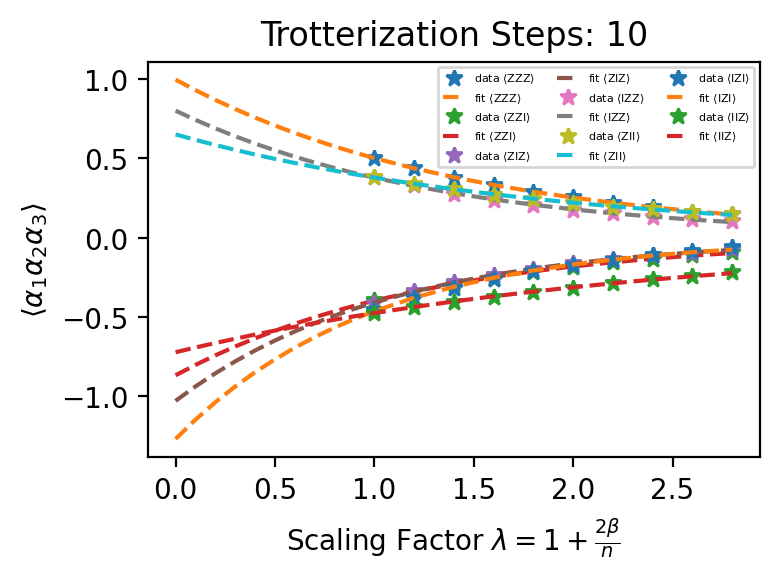

In [47]:
trotterization_step_n = 10
fig, ax = plt.subplots(1, figsize=(4, 3), dpi=200,)
ax.set_title(f"Trotterization Steps: {trotterization_step_n}")
for p in ["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"]:
    steps, metric = extract_metric(res_analysis, metric_func=lambda res: res["parity"][p], sweep_param_parser = unitary_folding_parser_factory(trotterization_step_n))
    fit_uf(steps, metric, plotting=True, ax=ax, label="$\\langle$" + p + "$\\rangle$")
ax.legend(ncol=3, fontsize=4)

Here, $\lambda$ is the overall circuit scaling factor, $n = 10$ is the number of trotterization steps, and $\beta$ is the number of Unitary Folding steps. Again, this means that the circuits we need to measure for Unitary Folding extrapolation have the form: (U_trott_gate$^\dagger$ U_trott_gate)^beta(U_trott_gate)$^n$|psi_init$\rangle$.

As $\lambda \to \infty$, we expect each parity measurement to decay to $0$ as the final quantum state produced by a noisy circuit with infinite gates should be a mixed (thermal) state. This motivates an exponential fit to the above curves. Moreover, we can extrapolate these fits to $\lambda \to 0$ to reach the zero noise limit extrapolated partiy measurements. 

Of course, we only wish to extrapolate fits with $r^2$ values (i.e. good fits). So, when the $r^2$ value is not high enough (as defined by a user of our software), we will not use the Unitary Folding extrapolated parity measurement and instead just use the parity measurement value at $\lambda = 1$ (or $\beta = 0$). 

Also, as shown above, some parity measurements dip slightly below $-1$ or slightly above $1$. Since these values are (just barely) unphysical but the fits are high quality, we cap these parity measurements to the range [-1, 1] so that an extrapolated parity measurement of -1.1 would be capped to -1. 

With this unitary folding technique, we are able to extrapolate parity measurements for each trotterization step number. These extrapolated parity measurements are then plotted below and compared to the values before extrapolation.

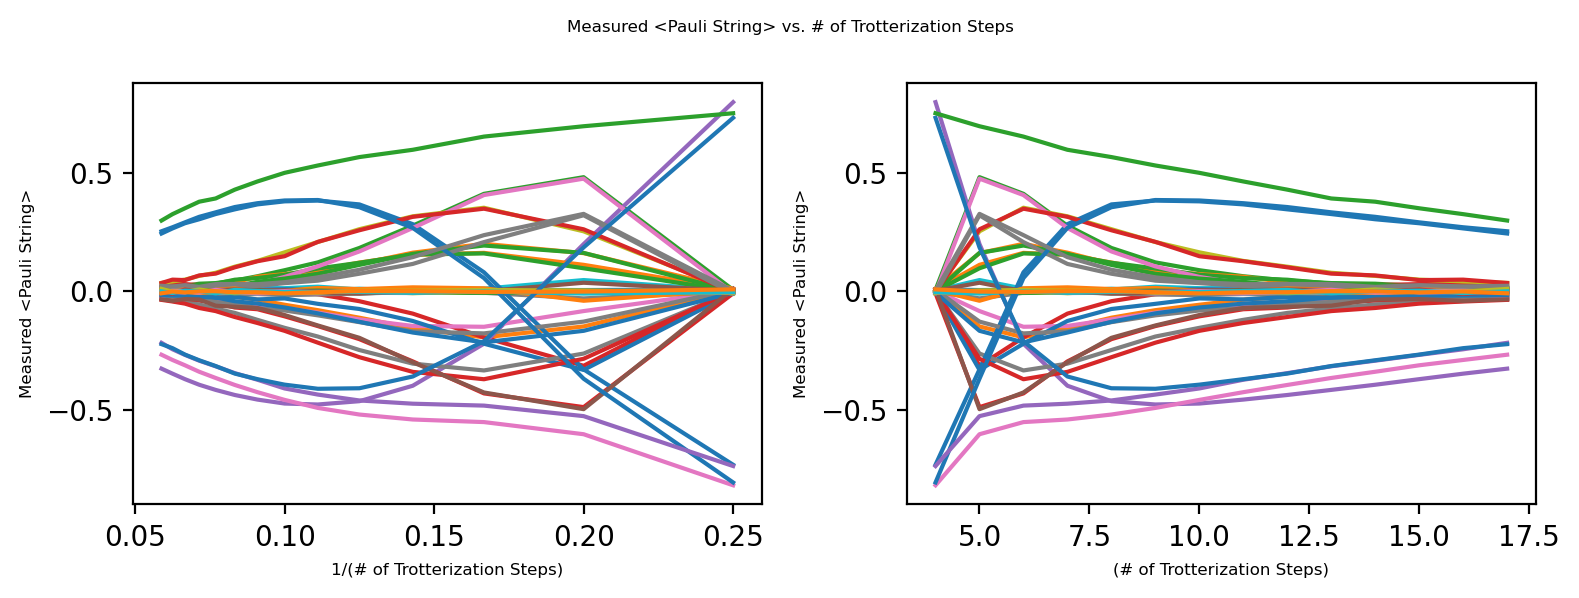

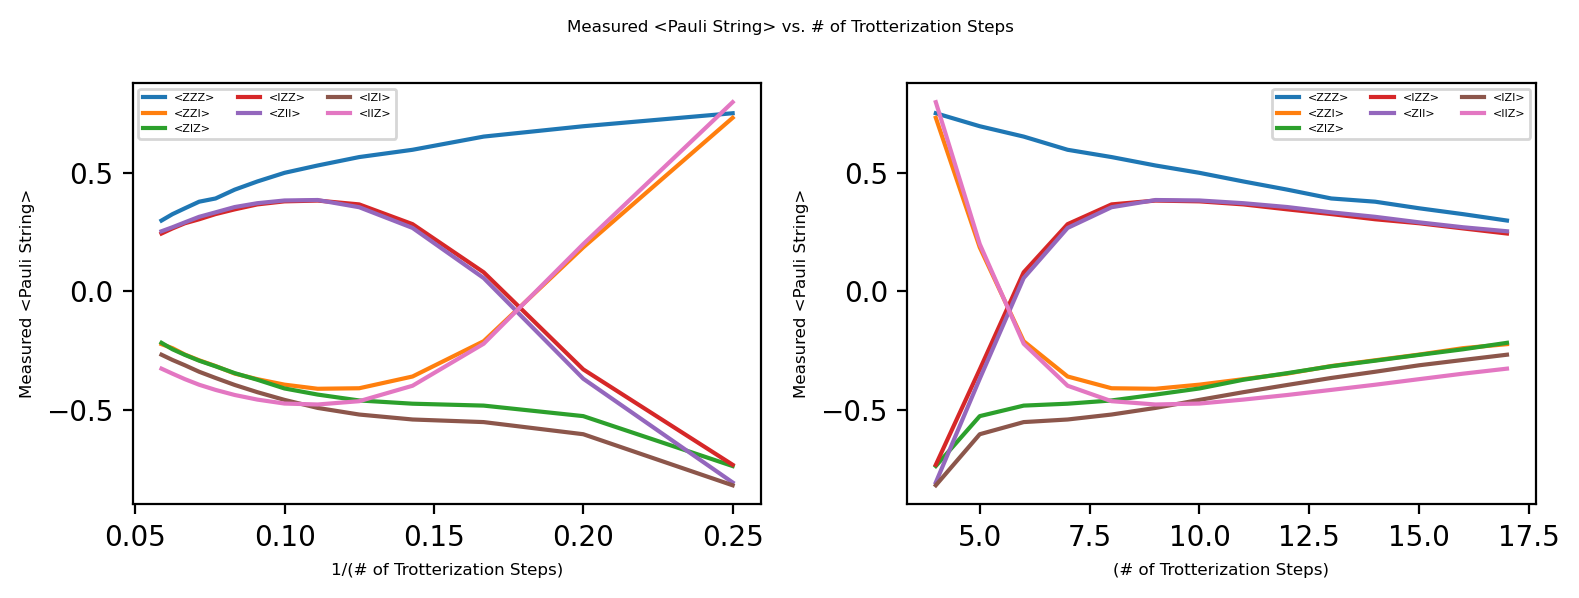

In [58]:
# before Unitary Folding extrapolation, here we plot parity measurements for beta = 0 for all trotterization step numbers n
axs = plot_parity(res_analysis) # all 63 parity measurements 
axs = plot_parity(res_analysis, parity_strings=["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"], legend=True)

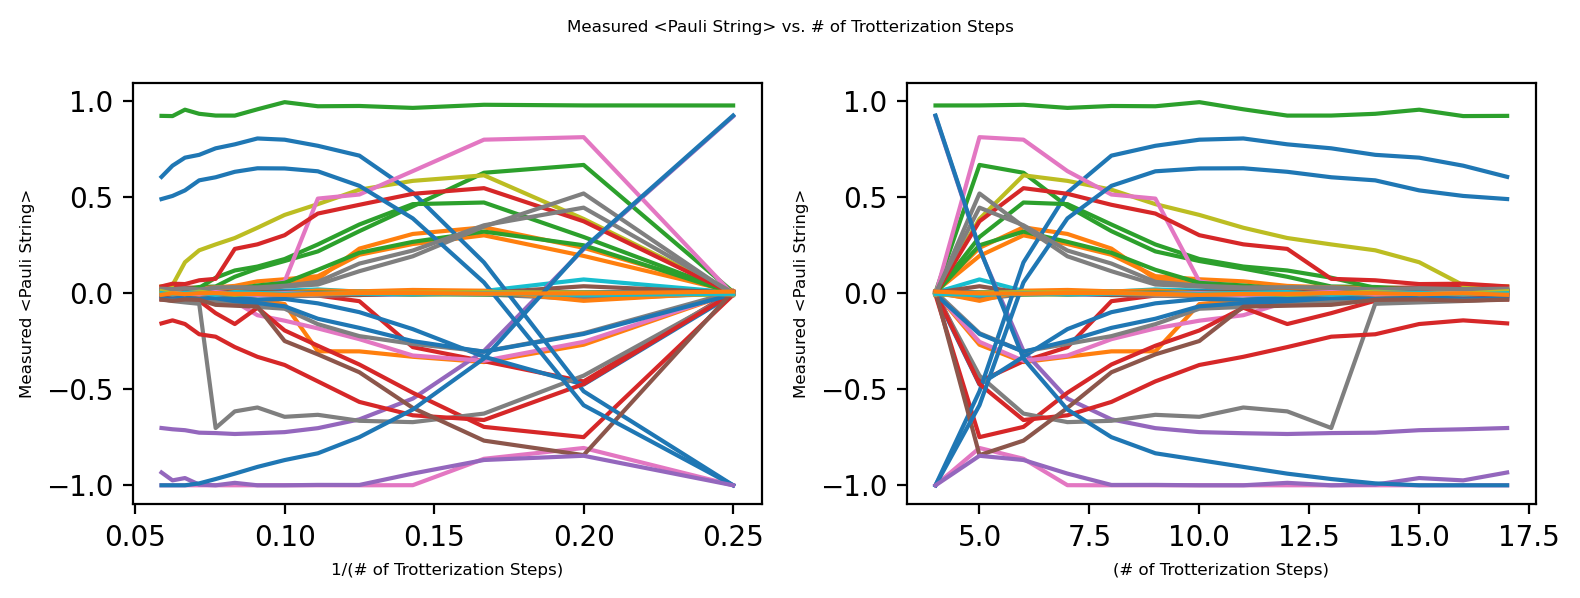

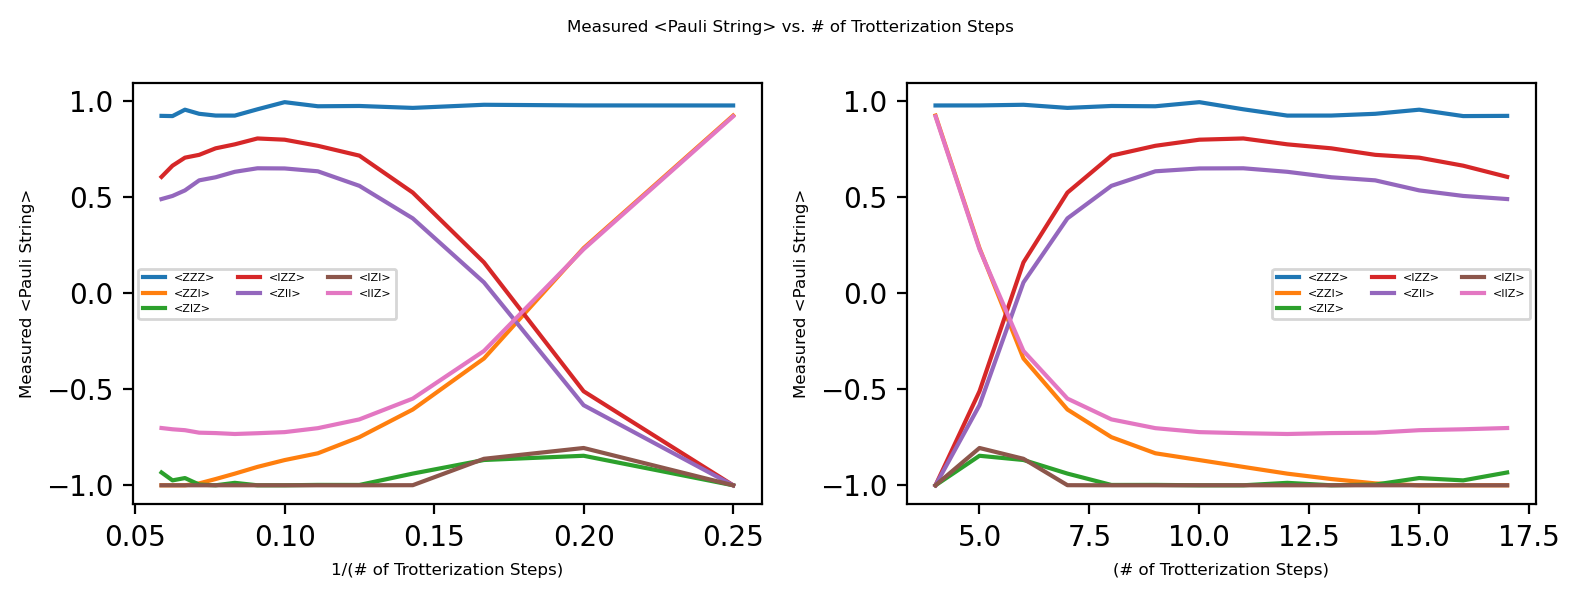

In [56]:
# after Unitary Folding extrapolation, where we calculate <alpha_1 alpha_2 alpha_3 > at lambda = 0 for each trotterization step, as described above
axs = plot_uf_parity(res_analysis) # all 63 parity measurements 
axs = plot_uf_parity(res_analysis, parity_strings=["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"], legend=True) # only the parity measurements we expect to be non-zero for the ideal target_state

We see a noticeable improvement in the parity measurement trends versus # of trotterization steps. Again, this analysis is performed on data generated by the noisy simulator modelled after `ibmq_jakarta`. 

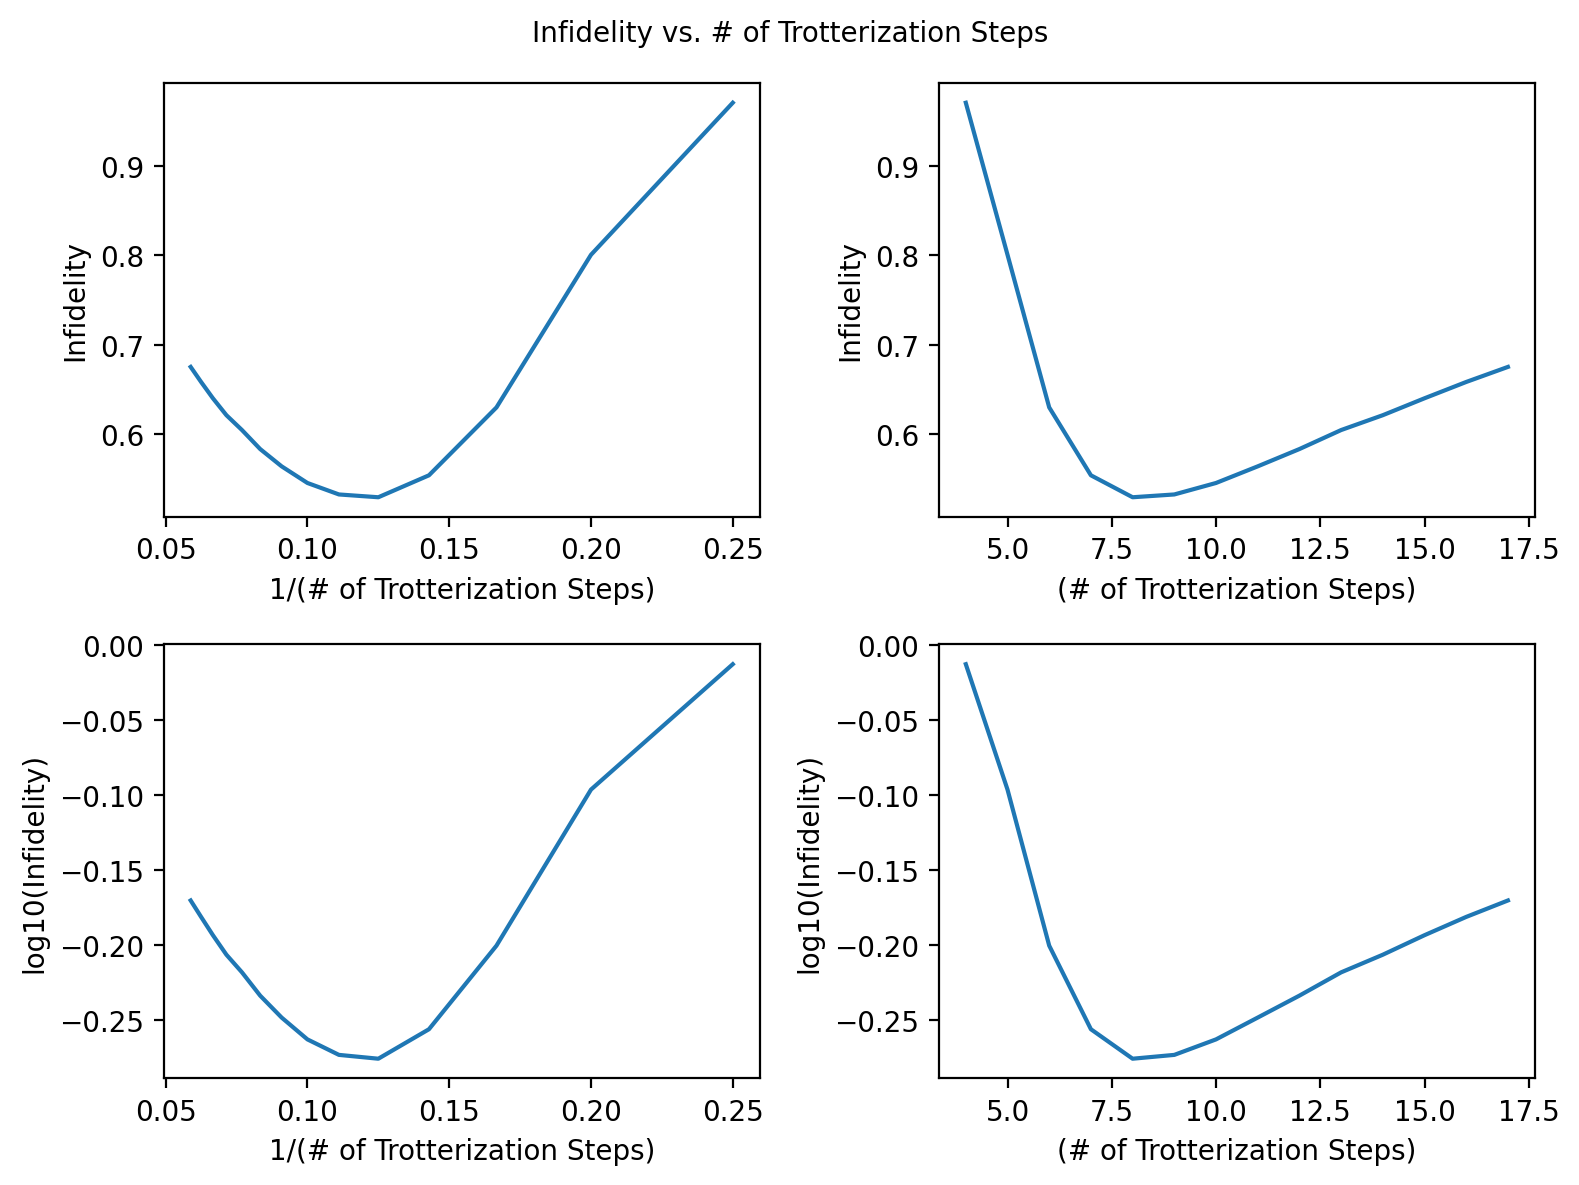

In [59]:
# before Unitary Folding extrapolation, here we plot infidelity of reconstructed state to target state for beta = 0 for all trotterization step numbers n
axs = plot_fidelities(res_analysis)

Maximum Fidelity:  0.85705125363458


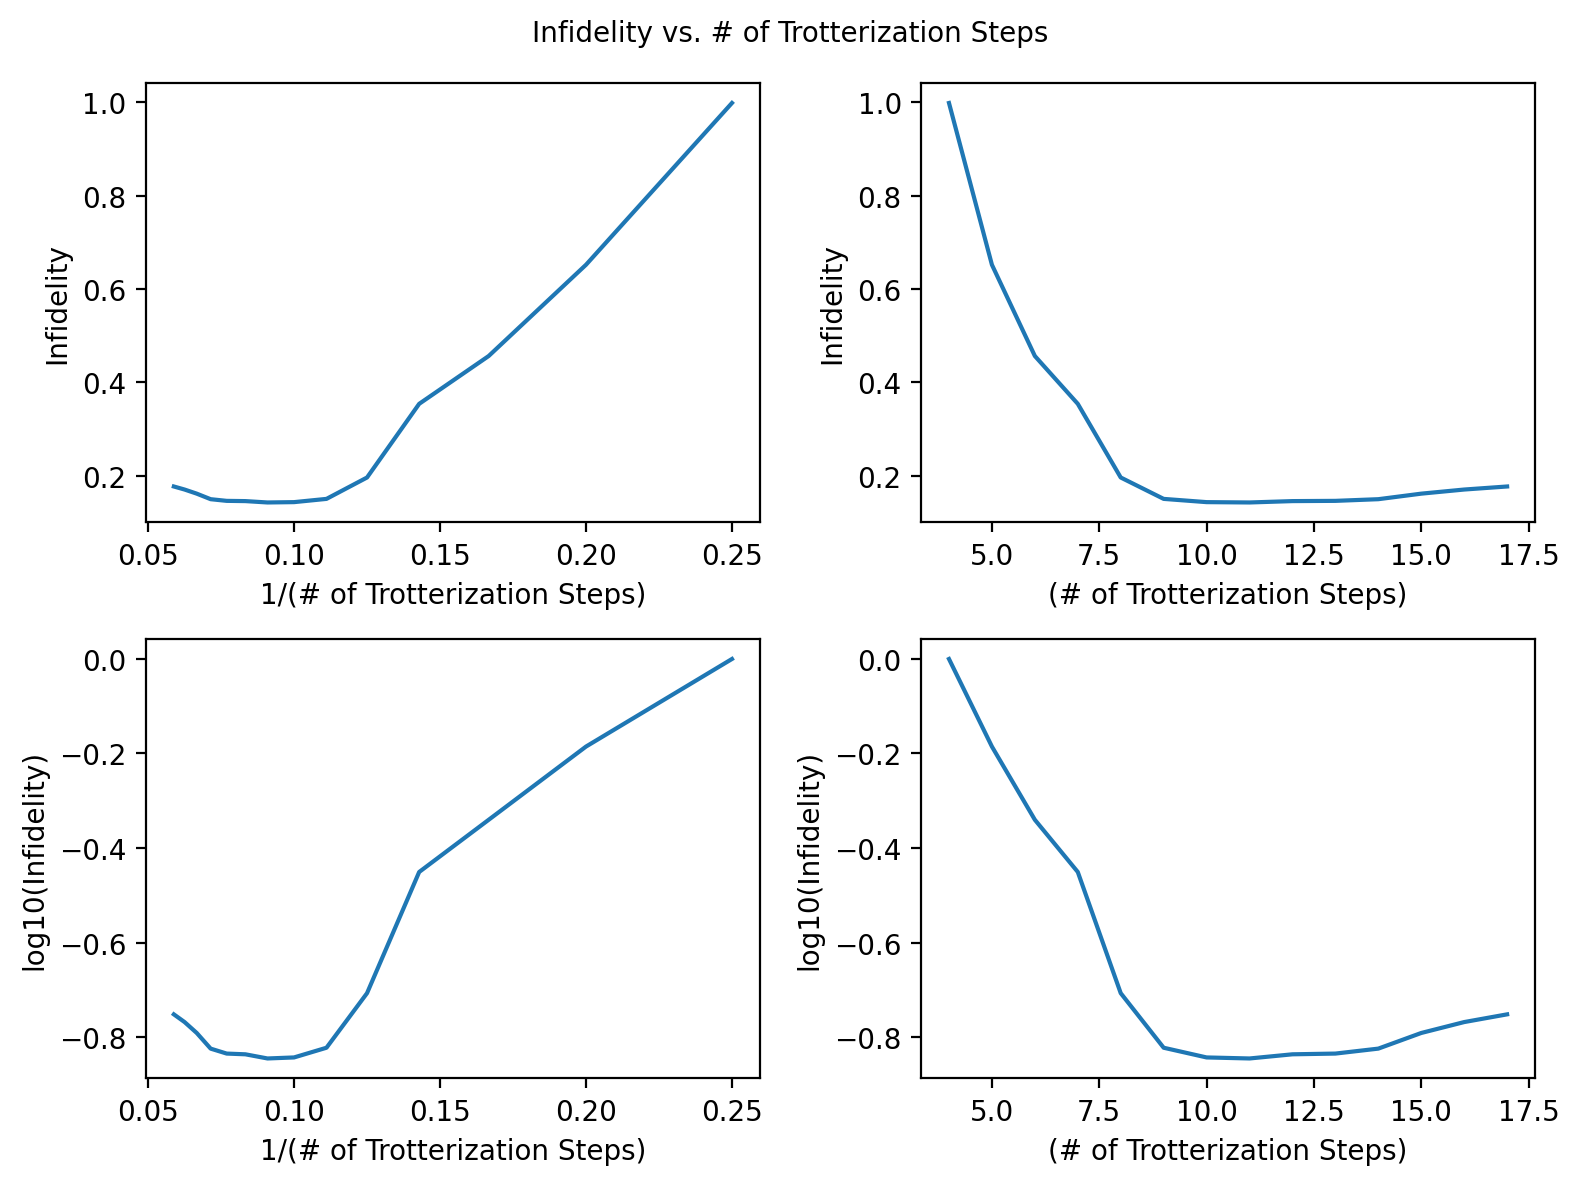

In [68]:
# after Unitary Folding extrapolation, here we plot infidelity of reconstructed state to target state for all trotterization step numbers n
axs = plot_fidelities(res_analysis, key="uf_infid", data_key="analysis")
print("Maximum Fidelity: ", 1 - res_analysis["analysis"][11]["uf_infid"])

We also see a significant boost of the maximum fidelity achieved at any trotterization step number after we use unitary folding. 

# Technique: Trotterization Error Mitigation

Now, using the parity measurements extrapolated at each trotterization step number after Unitary Folding Extrapolation, we can extrapolate parity measurements vs. trotterization step number itself. This is the novel technique of Trotterization Error Mitigation introduced in this work.

r^2:  0.06106852086819692
r^2:  0.9997096744734651
r^2:  0.996446201183396
r^2:  0.9974888011892974
r^2:  0.8897413791751907
r^2:  0.9986035789134577


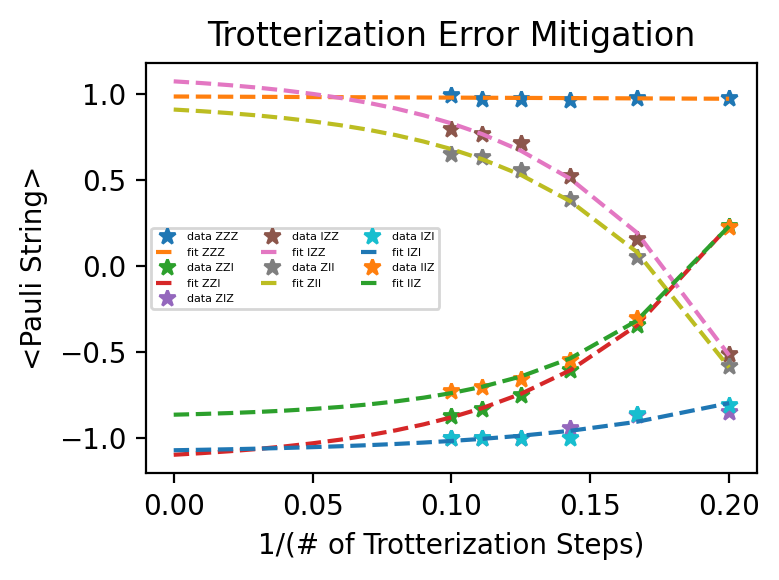

In [83]:
fig, ax = plt.subplots(1, figsize=(4, 3), dpi=200,)
ax.set_title(f"Trotterization Error Mitigation")
for ps in ["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"]:
    steps, metric = extract_metric(res_analysis, metric_func=lambda res: res["uf_parity"][ps], sweep_param_parser = trott_step_parser_factory(), data_key="analysis")
    fit_trott(steps, metric, plotting=True, y_label="<Pauli String>", ax=ax, label=ps)
ax.legend(ncol=3,fontsize=4)

As motivated in our paper, in some regime we expect an exponential decay versus 1/n, where n is the number of trotterization steps. This exponential decay is towards the parity values of the ideal target state, which we can extrapolate in the zero error limite of $1/n \to 0$. 

Again, there are nuances to the fits above. First, we choose a range of trotterization step values (in this case $n \in [5,10]$) over which to fit. Second, as in the case of Unitary Folding extrapolation, we only extrapolate using fits that exceed a specified $r^2$ threshold (in this case $r^2 > .99$). Finally, we again cap extrapolated parity measurements (of good fits) to the physical range of $[-1,1]$, as done in the case of Unitary Folding Extrapolation.

Finally, after running MLE quantum state tomography using the parity measurements extrapolated to $1/n \to 0$, we are able to get a reconstructed state with a 96.8% fidelity to the ideal target state of $|q_1q_3q_4\rangle = |011\rangle$, as shown below.

In [77]:
print("Fidelity of reconstructed state to target state: {:.5f}".format(1- res_analysis["total"]["trott_infid"]))

Fidelity of reconstructed state to target state: 0.96787


# Running on Real Hardware

We had a blast playing around with the simulators as well as `ibmq_jakarta` in this challenge. Thanks so much to IBMQ and organizers for arranging this access!

Unfortunately, although we submitted these circuits to `ibmq_jakarta` before the stated challenge deadline, we were unable to get results for the circuits necessary to perform Unitary Folding Extrapolation analysis. 

That said, because we have built out the software necessary to submit these circuits to real quantum hardware in an efficient method (as shown below), we invite the especially curious and patient reader to run these circuits and perform the above analysis on results from `ibmq_jakarta`. 

In [78]:
# Generate + Submit Jobs
# job_ids = gen_qpu_jobs(qcs, backend = jakarta, label="data/3cnot_qpu")

In [82]:
# Load Jobs
# job_ids = np.load("data/3cnot_qpu_jobs_20220414__193247.npy",allow_pickle=True).item() # Load Jobs

In [80]:
# Monitor / Store Results
# results = gen_qpu_results(qcs, job_ids, backend=jakarta, filename="data/3cnot_qpu_results_20220414__193247.npy")

In [81]:
# Load Results
# results = np.load("data/3cnot_qpu_results_20220414__193247.npy",allow_pickle=True).item()

# References

[1] https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

[2] https://arxiv.org/abs/2005.10921